<a href="https://www.kaggle.com/code/andrewchen2804/yolo-time?scriptVersionId=150349584" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
! pip install kaggle
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline
!rm -rf runs yolov5

!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt  # install dependencies
!cp yolov5/requirements.txt ./


!pip install ultralytics

#We get a pretrained model

Cloning into 'yolov5'...
remote: Enumerating objects: 16057, done.
remote: Total 16057 (delta 0), reused 0 (delta 0), pack-reused 16057
Receiving objects: 100% (16057/16057), 14.60 MiB | 27.23 MiB/s, done.
Resolving deltas: 100% (11032/11032), done.
  Obtaining dependency information for pycocotools from https://files.pythonhosted.org/packages/ba/64/0451cf41a00fd5ac4501de4ea0e395b7d909e09d665e56890b5d3809ae26/pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 15.9 MB/s eta 0:00:00


In [3]:
import ultralytics
ultralytics.checks()
from ultralytics import YOLO


Ultralytics YOLOv8.0.208 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5122.2/8062.4 GB disk)


In [4]:
h, w, channels = (380, 676, 3)
df = pd.read_csv('/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv')
print(df)
df['image'] = df['image'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['width_of_box'] = df['xmax'] - df['xmin']
df['height_of_box'] = df['ymax'] - df['ymin']
df['classes'] = 0
#Here we are normalizing our data
df['x_center'] = df['x_center']/w
df['width_of_box'] = df['width_of_box']/w
df['y_center'] = df['y_center']/h
df['height_of_box'] = df['height_of_box']/h
#df.head()

               image        xmin        ymin        xmax        ymax
0     vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1    vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2    vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3    vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4    vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422
..               ...         ...         ...         ...         ...
554   vid_4_9860.jpg    0.000000  198.321729   49.235251  236.223284
555   vid_4_9880.jpg  329.876184  156.482351  536.664239  250.497895
556   vid_4_9900.jpg    0.000000  168.295823  141.797524  239.176652
557   vid_4_9960.jpg  487.428988  172.233646  616.917699  228.839864
558   vid_4_9980.jpg  221.558631  182.570434  348.585579  238.192196

[559 rows x 5 columns]


Image ID: vid_4_3540


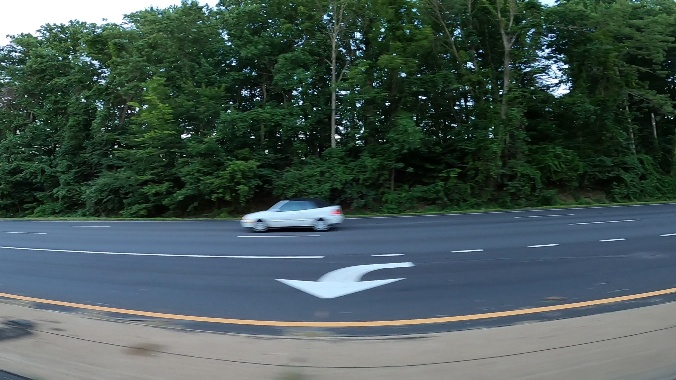

In [5]:
index = list(set(df.image))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'/kaggle/input/car-object-detection/data/training_images/{image}.jpg')
Image(filename=f'/kaggle/input/car-object-detection/data/training_images/{image}.jpg',width=600)

In [6]:
testing_set = []
for filename in os.listdir("/kaggle/input/car-object-detection/data/testing_images"):
    testing_set.append(filename)
#print(testing_set)

Image ID: vid_5_31020.jpg


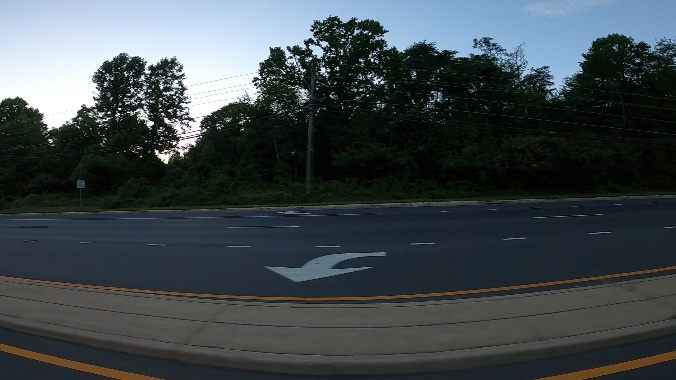

In [7]:
image = random.choice(testing_set)
print("Image ID: %s"%(image))
img = cv2.imread(f'/kaggle/input/car-object-detection/data/testing_images/{image}')
image = random.choice(testing_set)
Image(filename=f'/kaggle/input/car-object-detection/data/testing_images/{image}',width=600)

In [8]:
!python yolov5/train.py --batch 3 --epochs 1 --data ../input/yolov5-config/car.yaml --cfg ../input/yolov5-config/yolov5x.yaml --name yolov5x_fold0_new
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /kaggle/input/car-object-detection/data/testing_images

train: weights=yolov5/yolov5s.pt, cfg=../input/yolov5-config/yolov5x.yaml, data=../input/yolov5-config/car.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=1, batch_size=3, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=yolov5x_fold0_new, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: Ultralytics requirement ['Pillow>=10.0.1'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 10.8s, installed 1 package: ['Pillow>=10.0.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

Traceba

In [9]:
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("/kaggle/working/yolov5/runs/detect/exp"):
    predicted_files.extend(filenames)
#predicted_files

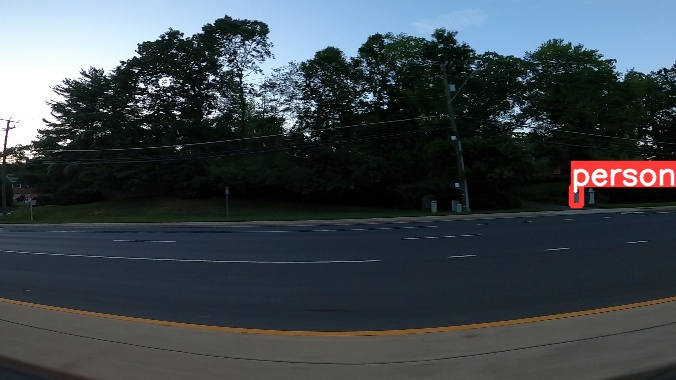

In [10]:
image = random.choice(testing_set)
Image(filename=f'/kaggle/working/yolov5/runs/detect/exp/{image}')
#random.choice(testing_set)

In [11]:
base_directory = '/kaggle/input/find-a-car-park/data'
Final_set = []
source = os.walk('/kaggle/input/find-a-car-park/data')

for root, dirs, files in os.walk(base_directory):
    for file in files:
        file_path = file
        # Save the file path relative to the base directory
        Final_set.append(file_path)
#print(Final_set)


    

In [12]:
#Trains the final set
#!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source '/kaggle/input/find-a-car-park/data/Free' --save-txt --save-conf --save-dir f'/kaggle/working/yolov5/runs/detect/exp3'
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source '/kaggle/input/find-a-car-park/data/Free'
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source '/kaggle/input/find-a-car-park/data/Full'


detect: weights=['yolov5/yolov5s.pt'], source=/kaggle/input/find-a-car-park/data/Free, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: Ultralytics requirement ['Pillow>=10.0.1'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 10.7s, installed 1 package: ['Pillow>=10.0.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
WARNING ⚠️ --img-size [676, 676] must be multiple of max stri

/kaggle/working/yolov5/runs/detect/exp/img_926054558.jpg
/kaggle/working/yolov5/runs/detect/exp2/img_926054558.jpg
/kaggle/working/yolov5/runs/detect/exp/img_926054558.jpg
/kaggle/working/yolov5/runs/detect/exp3/img_926054558.jpg
Found it


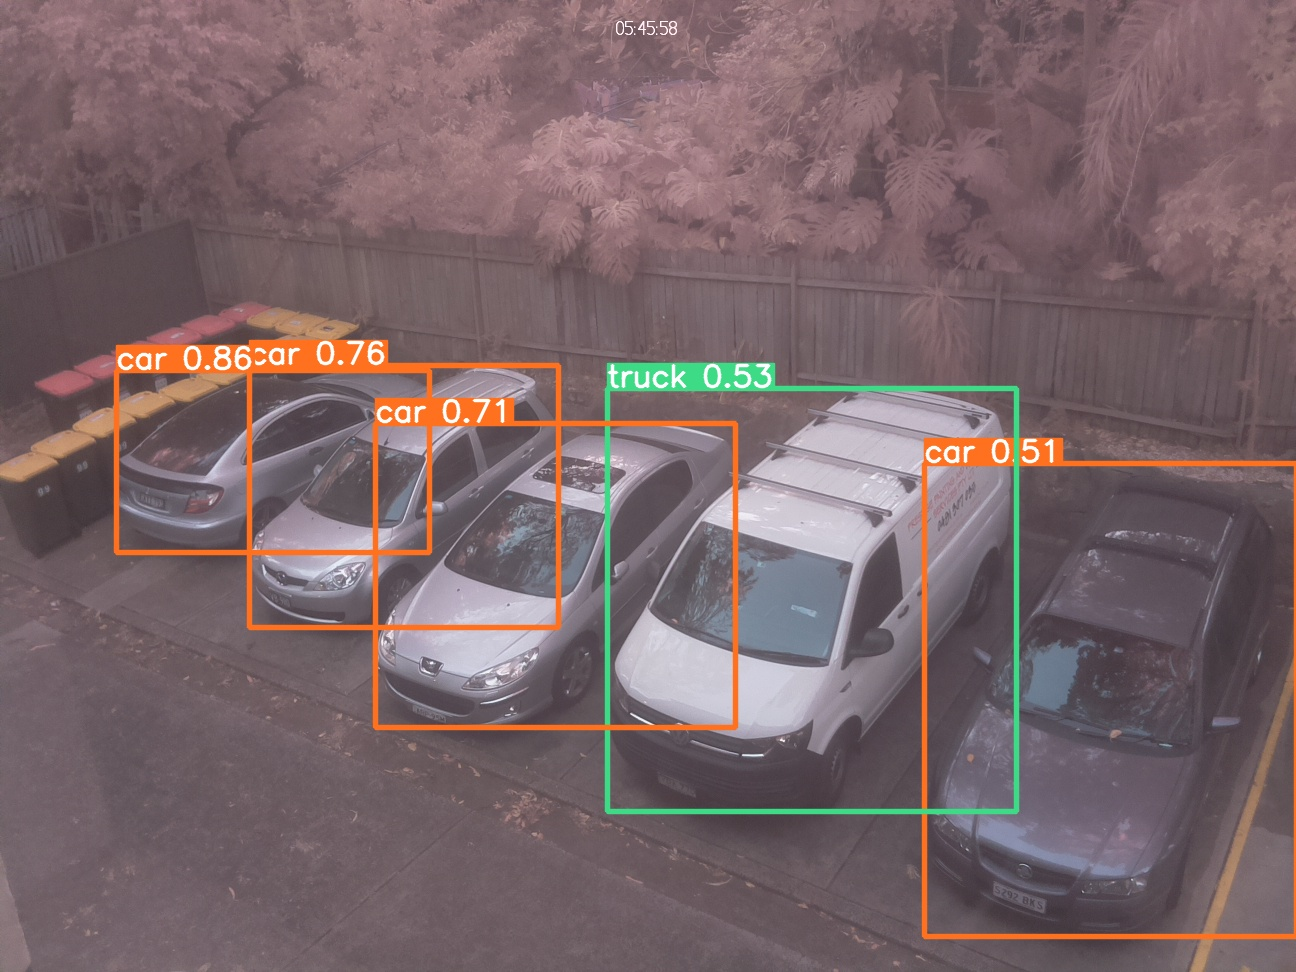

In [13]:
test2 = random.choice(Final_set)

print("/kaggle/working/yolov5/runs/detect/exp/"+test2)
#exp2_path = f'/kaggle/working/yolov5/runs/detect/exp2/{test2}'
#exp3_path = f'/kaggle/working/yolov5/runs/detect/exp3/{test2}'
base_directory = '/kaggle/working/yolov5/runs/detect'
for root, dirs, files in os.walk(base_directory):
    #print(root,dirs)
    
    for dir in dirs:
        dir_path = file
        print(root+"/"+dir+"/"+test2)
        if os.path.exists(root+"/"+dir+"/"+test2):
            print("Found it")
            source_path = root+"/"+dir+"/"+test2
            break;

Image(filename=source_path)